In [2]:
import os
import glob
import monai
import torch
import numpy as np 
from PIL import Image
from tqdm import tqdm
import SimpleITK as sitk
from statistics import mean
from torch.optim import Adam
from natsort import natsorted
import matplotlib.pyplot as plt
from transformers import SamModel 
import matplotlib.patches as patches
from transformers import SamProcessor
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import threshold, normalize
import cv2
import torchvision

from glob import glob


In [3]:
train_imgs = sorted(glob("/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/train_img/*.jpg"))
train_masks = sorted(glob("/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/train_masks/*.bmp"))

val_imgs = sorted(glob("/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/val_img/*.jpg"))
val_masks = sorted(glob("/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/val_masks/*.bmp"))





In [4]:
def get_bounding_box(ground_truth_map):
    
   
    
    if len(np.unique(ground_truth_map))>1:
        y_indices ,x_indices = np.where(ground_truth_map>0)
        x_min,x_max = np.min(x_indices),np.max(x_indices)
        y_min,y_max = np.min(y_indices),np.max(y_indices)
        
        
        H,W = ground_truth_map.shape
        x_min = max(0,x_min-np.random.randint(1,5))
        
        x_min = max(0, x_min - np.random.randint(1, 4))
        x_max = min(W, x_max + np.random.randint(1, 4))
        y_min = max(0, y_min - np.random.randint(1, 4))
        y_max = min(H, y_max + np.random.randint(1, 4))
        
        bbox = [x_min, y_min, x_max, y_max]

        return bbox
    else:
        return [0, 0, 256, 256]

In [5]:
class Iris(Dataset):
    def __init__(self,images,masks,processor):
        self.processor = processor
        self.images = images
        self.masks = masks
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img = np.array(Image.open(self.images[index]).resize((256,256)))
        mask = np.array(Image.open(self.masks[index]).convert("L").resize((256,256)))
        mask[mask > 0 ] = 1
        
        
        prompt = get_bounding_box(mask)
        
        
        
       
        
        # # # prepare image and prompt for the model
        inputs = self.processor(img, input_boxes=[[prompt]], return_tensors="pt")
        
        

        # # # remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        inputs["ground_truth_mask"] = torch.from_numpy(mask)
        
        return inputs

In [6]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [7]:
dataset = Iris(images=train_imgs,masks=train_masks,processor=processor)



pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask torch.Size([256, 256])


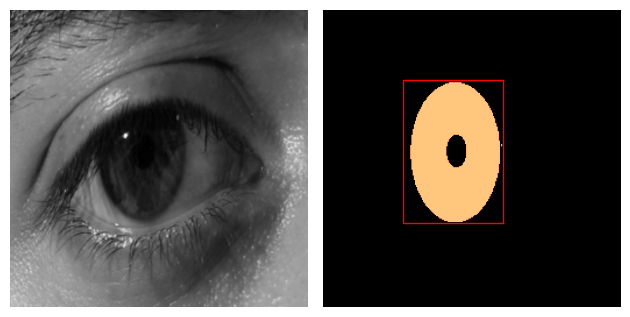

In [8]:
example = dataset[190]



for k,v in example.items():
    print(k,v.shape)
    
    
xmin,ymin,xmax,ymax = get_bounding_box(example["ground_truth_mask"])

fig,axs = plt.subplots(1,2)

axs[0].imshow(example["pixel_values"][1],cmap="gray")
axs[0].axis("off")


axs[1].imshow(example["ground_truth_mask"],cmap="copper")
rects = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth = 1,edgecolor="r",facecolor="none")
axs[1].add_patch(rects)

axs[1].axis("off")

plt.tight_layout()
plt.show()

In [9]:

train_dataset = Iris(train_imgs,train_masks,processor=processor)
train_dataloader = DataLoader(train_dataset,batch_size=1,shuffle=True)

val_dataset =  Iris(val_imgs,val_masks,processor=processor)
val_dataloader = DataLoader(val_dataset,batch_size=1,shuffle=False)

In [10]:
model = SamModel.from_pretrained("facebook/sam-vit-base")


# print(model)

for name,param in model.named_parameters():
    # print(name,param)
    
    print(name)
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

vision_encoder.pos_embed
vision_encoder.patch_embed.projection.weight
vision_encoder.patch_embed.projection.bias
vision_encoder.layers.0.layer_norm1.weight
vision_encoder.layers.0.layer_norm1.bias
vision_encoder.layers.0.attn.rel_pos_h
vision_encoder.layers.0.attn.rel_pos_w
vision_encoder.layers.0.attn.qkv.weight
vision_encoder.layers.0.attn.qkv.bias
vision_encoder.layers.0.attn.proj.weight
vision_encoder.layers.0.attn.proj.bias
vision_encoder.layers.0.layer_norm2.weight
vision_encoder.layers.0.layer_norm2.bias
vision_encoder.layers.0.mlp.lin1.weight
vision_encoder.layers.0.mlp.lin1.bias
vision_encoder.layers.0.mlp.lin2.weight
vision_encoder.layers.0.mlp.lin2.bias
vision_encoder.layers.1.layer_norm1.weight
vision_encoder.layers.1.layer_norm1.bias
vision_encoder.layers.1.attn.rel_pos_h
vision_encoder.layers.1.attn.rel_pos_w
vision_encoder.layers.1.attn.qkv.weight
vision_encoder.layers.1.attn.qkv.bias
vision_encoder.layers.1.attn.proj.weight
vision_encoder.layers.1.attn.proj.bias
vision_

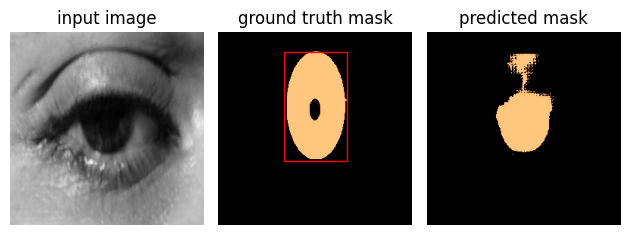

  2%|▏         | 25/1312 [00:15<13:07,  1.63it/s]


KeyboardInterrupt: 

In [11]:
# define training loop
num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# define optimizer
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# define segmentation loss with sigmoid activation applied to predictions from the model
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# track mean train and validation losses
mean_train_losses, mean_val_losses = [], []

# create an artibarily large starting validation loss value
best_val_loss = 100.0
best_val_epoch = 0

# set model to train mode for gradient updating
model.train()
for epoch in range(num_epochs):
    
    # create temporary list to record training losses
    epoch_losses = []
    for i, batch in enumerate(tqdm(train_dataloader)):

        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())
        
        # visualize training predictions every 50 iterations
        if i % 50 == 0:
            
            # clear jupyter cell output
            clear_output(wait=True)
            
            fig, axs = plt.subplots(1, 3)
            xmin, ymin, xmax, ymax = get_bounding_box(batch['ground_truth_mask'][0])
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

            axs[0].set_title('input image')
            axs[0].imshow(batch["pixel_values"][0,1], cmap='gray')
            axs[0].axis('off')

            axs[1].set_title('ground truth mask')
            axs[1].imshow(batch['ground_truth_mask'][0], cmap='copper')
            axs[1].add_patch(rect)
            axs[1].axis('off')
            
            # apply sigmoid
            medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
            
            # convert soft mask to hard mask
            medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
            medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

            axs[2].set_title('predicted mask')
            axs[2].imshow(medsam_seg, cmap='copper')
            axs[2].axis('off')

            plt.tight_layout()
            plt.show()
    
    # create temporary list to record validation losses
    val_losses = []
    
    # set model to eval mode for validation
    with torch.no_grad():
        for val_batch in tqdm(val_dataloader):
            
            # forward pass
            outputs = model(pixel_values=val_batch["pixel_values"].to(device),
                      input_boxes=val_batch["input_boxes"].to(device),
                      multimask_output=False)
            
            # calculate val loss
            predicted_val_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            val_loss = seg_loss(predicted_val_masks, ground_truth_masks.unsqueeze(1))

            val_losses.append(val_loss.item())
        
        # visualize the last validation prediction
        fig, axs = plt.subplots(1, 3)
        xmin, ymin, xmax, ymax = get_bounding_box(val_batch['ground_truth_mask'][0])
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

        axs[0].set_title('input image')
        axs[0].imshow(val_batch["pixel_values"][0,1], cmap='gray')
        axs[0].axis('off')

        axs[1].set_title('ground truth mask')
        axs[1].imshow(val_batch['ground_truth_mask'][0], cmap='copper')
        axs[1].add_patch(rect)
        axs[1].axis('off')

        # apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        axs[2].set_title('predicted mask')
        axs[2].imshow(medsam_seg, cmap='copper')
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

        # save the best weights and record the best performing epoch
        if mean(val_losses) < best_val_loss:
            torch.save(model.state_dict(), f"best_weights.pth")
            print(f"Model Was Saved! Current Best val loss {best_val_loss}")
            best_val_loss = mean(val_losses)
            best_val_epoch = epoch
        else:
            print("Model Was Not Saved!")
    
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    
    mean_train_losses.append(mean(epoch_losses))
    mean_val_losses.append(mean(val_losses))

